# Содержание:
    
<a name='content'></a>
[1. Подготовительная часть](#prepare)<br>
[2. Загрузка данных](#import_dataset)<br>
[3. Предобработка данных](#prepare_data)<br>
- [3.1. Исследование датафрейма и его преобразование](#prepare_data_refactor)<br>
- [3.2. Вывод](#conclusion_import_dataset)<br>
[4. Исследовательский анализ данных](#research_analyze)<br>
- [4.1. Анализ данных](#research_analyze_work)<br>
- [4.2. Вывод](#conclusion_research_analyze)<br>
[5. Объединение таблиц](#merge_table)<br>
- [5.1. Объединение трех таблиц](#merge_table_three_tables)<br>
- [5.2. Вывод](#conclusion_merge_table)<br>
[6. Корреляционный анализ](#correlation_analyze)<br>
- [6.1. Вывод](#correlation_analyze_matrix)<br>
- [6.2. Вывод](#conclusion_correlation_analyze)<br>
[7. Использование пайплайнов](#using_pipelines)<br>
- [7.5. Вывод](#conclusion_using_pipelines)<br>
[8. Анализ важности признаков](#analyze_importance)<br>
- [8.1. Анализ с применением shap](#analyze_importance_shap)<br>
- [8.2. Вывод](#conclusion_analyze_importance)<br>
[9. Сегментация покупателей](#customer_segmentation)<br>
- [9.1. Исследование потенциальных проблем](#customer_segmentation_research)<br>
- [9.2. Определение общего вывода снижения активности](#customer_segmentation_research_problems)<br>
- [9.3. Сегментация пользователей](#customer_segmentation_segmentation)<br>
- [9.4 Вывод](#conclusion_customer_segmentation)<br>
[10. Общий вывод](#conclusion)<br>

# Описание проекта:

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.<br>
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.<br>
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.<br>

Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.<br>
В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.<br>
Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Подготовительная часть
.[В содержание](#content)
<a name='prepare'></a>

Во избежание возможных ошибок связанных с работой библиотек следует обновить их до последних версий, а также установить недостающие

### Установка/обновление библиотек

In [1]:
# !pip install phik  -q # -q убирает необязательные выводы в командах Linux
# !pip install scikit-learn==1.4.0
# !pip install shap==0.45.1
# !pip install optuna-integration

In [3]:
# !pip install matplotlib==3.8.4
# !pip install seaborn==0.13.2

### Импорт библиотек

<i>Работа с данными, визуализация<i>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Матрица корреляции

In [4]:
from phik.report import plot_correlation_matrix
from phik import phik_matrix

Библиотека sklearn

In [5]:
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем функцию для проверки значимости показателей в модели
from sklearn.inspection import permutation_importance

# загружаем функцию для ...
# from sklearn.datasets import make_classification

# импортируем класс OptunaSearchCV
from optuna.integration import OptunaSearchCV 

SHAP

In [6]:
import shap

Настройка pandas

In [7]:
pd.set_option('display.max_colwidth', None)

## Загрузка данных
.[В содержание](#content)
<a name='import_dataset'></a>

In [8]:
market_action = pd.read_csv('/datasets/market_file.csv')
market_evenue = pd.read_csv('/datasets/market_money.csv')
market_period = pd.read_csv('/datasets/market_time.csv')
evenue_3m = pd.read_csv('/datasets/money.csv',
                       delimiter=';')

## Предобработка данных
[В содержание](#content)
<a name='prepare_data'></a>

### Исследование датафреймов и их преобразование
[В содержание](#content)
<a name='prepare_data_refactor'></a>

Просмотр информации исследуемых датасетов

In [9]:
display(market_action.head(1))
display(market_evenue.head(1))
display(market_period.head(1))
display(evenue_3m.head(1))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0


,id,Период,минут
0,215348,текущий_месяц,14


,id,Прибыль
0,215348,"0,98"


в таблице evenue_3m (выручка маркета) столбец "Прибыль" с ',' вместо '.'. В последствии подвергнется преобразованию

In [10]:
display(market_action.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

In [11]:
display(market_evenue.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

In [12]:
display(market_period.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

In [13]:
display(evenue_3m.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None

в таблице evenue_3m (среднемесячная выручка клиентов) столбец "Прибыль" заменим ',' на '.' и присвоем корректный тип данных.

In [14]:
evenue_3m['Прибыль'] = evenue_3m['Прибыль'].str.replace(",", ".").astype('float')

In [15]:
display(evenue_3m.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

Для единого формата названия столбцов приведем названия столбцов к одному формату "текст_..._текст"

In [16]:
def raplace_name_column(name_table):
    name_table.columns = map(lambda s: s.lower().replace(" ", "_"), name_table.columns)
    display(name_table.columns)

In [17]:
raplace_name_column(market_action)
raplace_name_column(market_evenue)
raplace_name_column(market_period)
raplace_name_column(evenue_3m)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Index(['id', 'период', 'выручка'], dtype='object')

Index(['id', 'период', 'минут'], dtype='object')

Index(['id', 'прибыль'], dtype='object')

### Вывод
.[В содержание](#content)
<a name='conclusion_import_dataset'></a>

1) В таблице по среднемесячной выручке преобразованы значения и изменен тип данных столцба "Прибыль";<br>
2) Названия столбцов в таблах были приведены к единому стандарту

## Исследовательский анализ данных
.[В содержание](#content)
<a name='research_analyze'></a>

### Анализ данных
.[В содержание](#content)
<a name='research_analyze_work'></a>

#### market_action

Для общего анализа сначала будут рассмотрены гистрограммы по численным значениям датасетов

Функция для построения гистограмм без 'id' и отобраения статистических данных

In [18]:
def describe_hist(name_table, drop_column='id'):
    if drop_column!= None:
        display(name_table.drop(drop_column, axis=1).describe())
        name_table.drop(drop_column, axis=1).hist(bins=50)
    else:
        display(name_table.describe())
        name_table.hist(bins=50)

Для лучшего отображения гистограмм таблицы по поведению покупателя с маркетом будет выводиться максимум по 4 гистограммы

In [19]:
num_names = list(market_action.select_dtypes(include='number').columns)
l_1 = num_names[1:5]
l_2 = num_names[5:]

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки
count,1300.000000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808
std,1.014814,0.696868,249.856289,0.249843
min,0.900000,3.000000,110.000000,0.000000
25%,3.700000,4.000000,405.500000,0.170000
50%,4.200000,4.000000,606.000000,0.240000
75%,4.900000,4.000000,806.000000,0.300000
max,6.600000,5.000000,1079.000000,0.990000


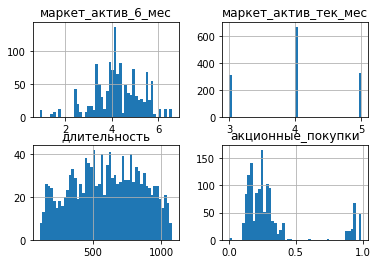

In [20]:
describe_hist(market_action[l_1], drop_column=None)

1) По статистическим данным не наблюдается особенностей;<br>
2) Значения по акционным покупкам могут быть подвержены ранжированию, поскольку наблюдается два выделяющихся участка

,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.00000,1300.000000,1300.000000,1300.000000
mean,3.27000,2.840000,4.185385,8.176923
std,1.35535,1.971451,1.955298,3.978126
min,1.00000,0.000000,0.000000,1.000000
25%,2.00000,1.000000,3.000000,5.000000
50%,3.00000,3.000000,4.000000,8.000000
75%,4.00000,4.000000,6.000000,11.000000
max,6.00000,10.000000,9.000000,20.000000


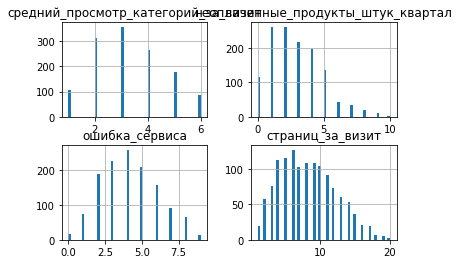

In [21]:
describe_hist(market_action[l_2], drop_column=None)

1) По статистическим данным не наблюдается особенностей;<br>
2) Все показания похожи на смещенное нормальное распределение

Исследование строковых значений по датасетам

In [22]:
for i in market_action.drop(num_names, axis=1).columns:
    print(f"""{i} : \n{market_action[i].value_counts()}\n""")

покупательская_активность : 
Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

тип_сервиса : 
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

разрешить_сообщать : 
да     962
нет    338
Name: разрешить_сообщать, dtype: int64

популярная_категория : 
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64



В столбце "тип_сервиса" обнаружен неявный дубликат "стандартт". Следует заменить. 

In [23]:
market_action['тип_сервиса'] = market_action['тип_сервиса'].str.replace("стандартт",
                                                                       "стандарт")
print(market_action['тип_сервиса'].value_counts())

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64


#### market_evenue

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


Text(0, 0.5, 'частота')

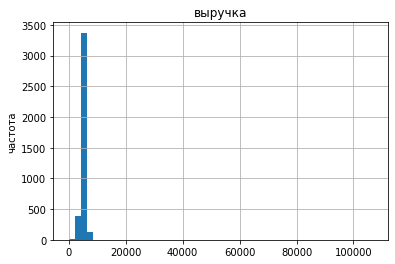

In [24]:
describe_hist(market_evenue)

plt.ylabel('частота')

По статистическим данным таблицы по данным прибыли маркета имеется выбивающееся значение по выручке. Его стоит убрать.

        id         период   выручка
98  215380  текущий_месяц  106862.2


,выручка
count,3899.00000
mean,4999.57743
std,706.99988
min,0.00000
25%,4590.10000
50%,4957.00000
75%,5363.00000
max,7799.40000


Text(0, 0.5, 'частота')

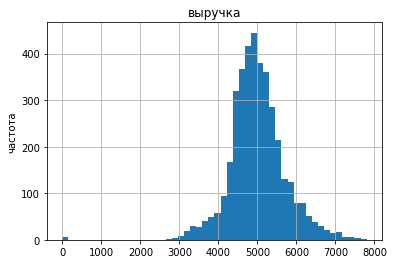

In [25]:
lest_index_max = market_evenue[market_evenue['выручка'] == market_evenue['выручка'].max()]
print(lest_index_max)
market_evenue = market_evenue[market_evenue['выручка'] < market_evenue['выручка'].max()]
describe_hist(market_evenue)

plt.ylabel('частота')

Распределение приблизилок к нормальному

In [26]:
num_names = list(market_evenue.select_dtypes(include='number').columns)
for i in market_evenue.drop(num_names, axis=1).columns:
    print(f"""{i} : \n{market_evenue[i].value_counts()}\n""")

период : 
препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1299
Name: период, dtype: int64



#### market_period

Прсомотр численных значений

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


Text(0, 0.5, 'частота')

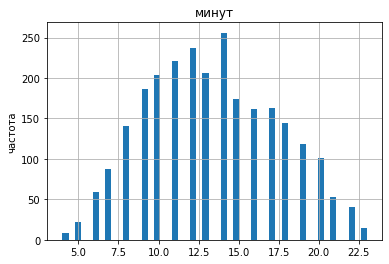

In [27]:
describe_hist(market_period)

plt.ylabel('частота')

Распределение ппохоже на нормальное

Исследование строковых значений

In [28]:
num_names = list(market_period.select_dtypes(include='number').columns)
for i in market_period.drop(num_names, axis=1).columns:
    print(f"""{i} : \n{market_period[i].value_counts()}\n""")

период : 
текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64



Замечена опечатка, стоит заменить

In [29]:
market_period['период'] = market_period['период'].str.replace("предыдцщий_месяц",
                                                             "предыдущий_месяц")

#### evenue_3m

Прсомотр численных значений

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Text(0, 0.5, 'частота')

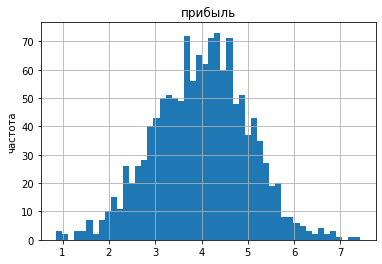

In [30]:
describe_hist(evenue_3m)

plt.ylabel('частота')

Распределение ппохоже на нормальное

In [31]:
num_names = list(evenue_3m.select_dtypes(include='number').columns)
for i in evenue_3m.drop(num_names, axis=1).columns:
    print(f"""{i} : \n{evenue_3m[i].value_counts()}\n""")

строковых значений нет

#### Фильтрация 3месячной активности клиентов

Для более качественного анализа отфильтруем тех, по кому данные присуствуют за все 3 месяца

In [32]:
market_evenue = market_evenue[market_evenue['выручка'] > 0]

In [33]:
agg_market_evenue = market_evenue.pivot_table(index='id',
                                              values='период',
                                              aggfunc='count').reset_index(drop=False)
agg_market_evenue.columns = ['id', 'count_id']
agg_market_evenue.head()

,id,count_id
0,215348,1
1,215349,3
2,215350,3
3,215351,3
4,215352,3


In [34]:
list_ids = agg_market_evenue[agg_market_evenue['count_id'] < 3]['id']
display(list_ids.head())
list_ids = list(list_ids)
print(list_ids)

0     215348
9     215357
11    215359
32    215380
Name: id, dtype: int64

[215348, 215357, 215359, 215380]


In [35]:
print(len(market_evenue))
market_evenue = market_evenue[market_evenue['id'].isin(list_ids) == False]
len(market_evenue)

3893


3888

### Вывод
.[В содержание](#content)
<a name='conclusion_research_analyze'></a>

1) В таблице marker_evenue убрана запись с выбивающимся значением по прибыли;<br>
2) Все распределения по численным значениям имеют распределение  близкое на смещенное нормальное распределение;<br>
3) Заменен неянвый дубликат в таблице market_action;<br>
4) Заменены найденные опечатки в строковых значениях

## Объединение таблиц
.[В содержание](#content)
<a name='merge_table'></a>

### Объединение трех таблиц
.[В содержание](#content)
<a name='merge_table_three_tables'></a>

Для начала необходимо определить периоды в таблицах для коректного моединения таблиц дял объединения под вид для построения моделей

In [36]:
display(market_evenue['период'].unique(), '\n')
display(market_period['период'].unique(), '\n')

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

'\n'

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

'\n'

Функция для получения таблицы с периодами по столбцам вместо строк

In [37]:
def tabale_dif_period(name_table, name_column:str, list_filter:list, rename_column:list):
    check_len = len(list_filter)
    
    name_table_new = name_table[name_table[name_column] == list_filter[0]].drop(columns=name_column)
    name_table_new = name_table_new.rename(columns=rename_column[0])
    
    if check_len > 1:
        for i in range(1, check_len):
            name_table_new_1 = name_table[name_table[name_column] == list_filter[i]].drop(columns=name_column)
            name_table_new_1 = name_table_new_1.rename(columns=rename_column[i])
            name_table_new = name_table_new.merge(name_table_new_1, how='outer', on='id')
    return name_table_new

In [38]:
market_money_pivot = market_evenue.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum').reset_index()
market_money_pivot.head()

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [39]:
market_evenue_dif = tabale_dif_period(name_table=market_evenue,
                                      name_column='период',
                                      list_filter=['текущий_месяц',
                                                   'предыдущий_месяц',
                                                   'препредыдущий_месяц'],
                                      rename_column=[{'выручка':'выручка_0m'},
                                                     {'выручка':'выручка_1m'},
                                                     {'выручка':'выручка_2m'}])

In [40]:
market_evenue_dif.head()

,id,выручка_0m,выручка_1m,выручка_2m
0,215349,4971.6,5216.0,4472.0
1,215350,5058.4,5457.5,4826.0
2,215351,6610.4,6158.0,4793.0
3,215352,5872.5,5807.5,4594.0
4,215353,5388.5,4738.5,5124.0


In [41]:
market_period_dif = tabale_dif_period(name_table=market_period,
                                      name_column='период',
                                      list_filter=['текущий_месяц',
                                                   'предыдущий_месяц'],
                                      rename_column=[{'минут':'минут_0m'},
                                                     {'минут':'минут_1m'}])

In [42]:
market_period_dif.head()

,id,минут_0m,минут_1m
0,215348,14,13
1,215349,10,12
2,215350,13,8
3,215351,13,11
4,215352,11,8


Финальное объединение таблиц

In [43]:
full_data = market_action.merge(market_evenue_dif, on='id', how='inner')
full_data = full_data.merge(market_period_dif,
                            on=['id'],
                            how='inner').reset_index(drop=True)

In [44]:
full_data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_0m,выручка_1m,выручка_2m,минут_0m,минут_1m
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [45]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Вывод
.[В содержание](#content)
<a name='conclusion_merge_table'></a>

1) Для объеденения таблицы market_period и market_evenue были преобразованы по периодам.
Данные по периодам были перемещены в столбцы;<br>
2) В итоговых таблицах убраны данные по одному id. Это следствие избавления от выбивающихся данных таблицы market_evenue.

## Корреляционный анализ
.[В содержание](#content)
<a name='correlation_analyze'></a>

### Корреляционная матрица
.[В содержание](#content)
<a name='correlation_analyze_matrix'></a>

Для корреляционного анализа рассмотрим матрицу корреляции. Для этого отберем численные данные

In [46]:
list(full_data.select_dtypes(include='number').columns)[1:]

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_0m',
 'выручка_1m',
 'выручка_2m',
 'минут_0m',
 'минут_1m']

In [47]:
# создаём список с наименованиями непрерывных признаков
interval_cols = list(full_data.select_dtypes(include='number').columns)[1:]

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(full_data.drop(columns='id'), interval_cols=interval_cols) 

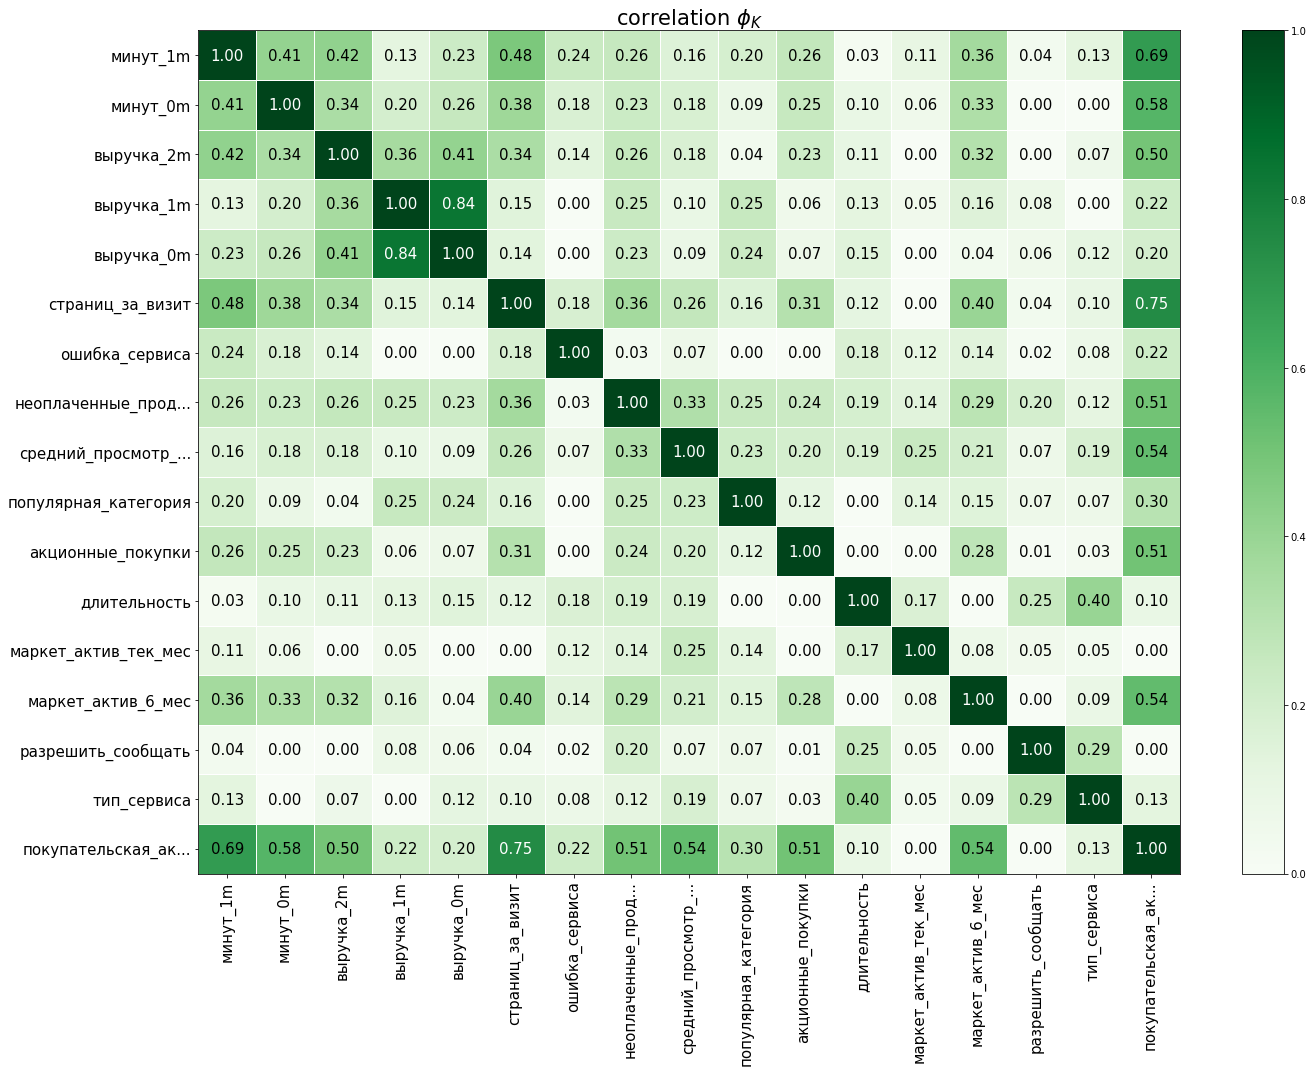

In [48]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

### Вывод
.[В содержание](#content)
<a name='conclusion_correlation_analyze'></a>

1) Большая часть признаков имеет коэффициент кореляции в диапозоне [0-0.2], но в то же время если с одним из признаков корреляция около правой границы дииапозона, то как правило наблюдается связь этого признака с другими;<br>
2) Наблюдается явная связь покупательской активности с временем проводимым на сайте и активностью магазина;<br>
3) Мультколлериарности не обнаружено;<br>
4) Выручка связана с ней же за другие периоды;<br>
5) Наблюдается выраженная связь выручки и акционныых покупок.

## Использование пайплайнов
.[В содержание](#content)
<a name='using_pipelines'></a>

### Подготовка данных для использования

Константы для моделей

In [49]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [50]:
full_data.tail(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_0m,выручка_1m,выручка_2m,минут_0m,минут_1m
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7,14
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11,12
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18,12
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,4725.0,7,18
1295,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,4448.3,4720.0,5183.0,10,15


Из датасета для обучения и проверки убирается столбец 'id'

In [51]:
full_data_use = full_data.drop('id', axis=1)

проверка и кодирование целевого признака покупательской активности, а также просмотр категориальных признаков для OneHotEncoder и OrdinalEncoder

In [52]:
target_feature = 'покупательская_активность'

print(full_data_use[target_feature].unique())
print(full_data_use['тип_сервиса'].unique())
print(full_data_use['популярная_категория'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандарт']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Кухонная посуда' 'Техника для красоты и здоровья'
 'Мелкая бытовая техника и электроника']


In [53]:
full_data_use['покупательская_активность'] = full_data_use['покупательская_активность'].apply(
    lambda x: 1 if x == 'Прежний уровень' else 0
)

In [54]:
full_data_use.tail(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_0m,выручка_1m,выручка_2m,минут_0m,минут_1m
1291,1,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7,14
1292,1,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11,12
1293,1,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18,12
1294,1,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,4725.0,7,18
1295,1,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,4448.3,4720.0,5183.0,10,15


Обозначение столбцов для кодирования и масштабирования

In [55]:
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['тип_сервиса']
num_columns = list(full_data.select_dtypes(include='number').columns)[1:]

Разбиение датасета на обучающую и тренировочную выборки

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_use.drop(target_feature, axis=1),
    full_data_use[target_feature],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = full_data_use[target_feature])

In [57]:
X_train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_0m,выручка_1m,выручка_2m,минут_0m,минут_1m
409,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,3713.8,4252.0,5023.0,18,12
1273,стандарт,да,3.4,5,351,0.24,Кухонная посуда,5,1,6,8,5000.0,4337.0,4949.0,13,15
24,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5633.1,5253.5,4715.0,9,8
38,стандарт,да,3.1,4,152,0.33,Косметика и аксесуары,6,4,2,5,4612.8,4254.0,4549.0,12,8
633,стандарт,да,5.5,5,541,0.17,Мелкая бытовая техника и электроника,4,1,6,5,5661.0,5388.0,5223.0,11,12


### Создание пайплайнов

Для работы с пайплайнами будет использован один общий пайплайн с моделями:
- KNeighborsClassifier,
- DecisionTreeClassifier,
- LogisticRegression,
- SVC

Пайплайны создаются в порядке:<br>
1) Кодирование;<br>
2) Масштабирование;<br>
3) Модель для обучения.

Пайплайн кодирования

В качестве ранжированного значения отобран параметр "тип_сервиса", где 0 - стандарт, 1 - премиум

In [58]:
ohe_model = OneHotEncoder(drop='first',
                          handle_unknown='ignore',
                          sparse_output=False)
ord_model = OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )

In [59]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan,
                                         strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first',
                          handle_unknown='ignore',
                          sparse_output=False))
    ]
    )

In [60]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan,
                                                strategy='most_frequent')),
     ('ord', OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan,
                                               strategy='most_frequent'))
    ]
)

In [61]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [62]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Пайплайн модели с масштабированием (StandardScaler(), MinMaxScaler(), 'passthrough')

In [63]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели SVC()
    {
        'models': [SVC(
            probability= True,
            kernel='poly',
            random_state=RANDOM_STATE
        )],
        'models__degree': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

### Поиск лучшей модели

Для поиска лучше модели используется RandomizedSearchCV как самый быстрый вариант

In [64]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория',
                                                                                'разрешить_сообщать']),
                                                                              ('ord',
                                                                               Pipelin...
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [65]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
# y_test_pred = randomized_search.predict(X_test)
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                 

1) Лучшей моделью оказалась логистическая регрессия с приемлемым ROC-AUC=0.905 на тренировочных данных;<br>
2) ROC-AUC на тестовой выборке оказался адекватным

In [66]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
7,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.904743,"{'preprocessor__num': MinMaxScaler(), 'models__C': 6, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
9,2,KNeighborsClassifier(),0.869654,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier()}"
6,3,KNeighborsClassifier(),0.865890,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 6, 'models': KNeighborsClassifier()}"
0,4,DecisionTreeClassifier(random_state=42),0.842159,"{'preprocessor__num': StandardScaler(), 'models__max_features': 8, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
5,5,DecisionTreeClassifier(random_state=42),0.839466,"{'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
4,6,DecisionTreeClassifier(random_state=42),0.832564,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
1,7,DecisionTreeClassifier(random_state=42),0.819075,"{'preprocessor__num': StandardScaler(), 'models__max_features': 9, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
3,8,DecisionTreeClassifier(random_state=42),0.811141,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
8,9,DecisionTreeClassifier(random_state=42),0.809982,"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
2,10,DecisionTreeClassifier(random_state=42),0.771916,"{'preprocessor__num': StandardScaler(), 'models__max_features': 5, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


### Отбор лучшей модели

Для дальнейшего исследования выбираем лучшую модель, обучаем преобразование данных и получаем имена для дальнейшего анализа

In [67]:
X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
best_model_linear = randomized_search.best_estimator_.named_steps['models']
features_names_X = list(pipe_final.named_steps['preprocessor'].get_feature_names_out())

### Вывод
.[В содержание](#content)
<a name='conclusion_using_pipelines'></a>

1) Для работы с моделью данные  были преобразованы в подходящий вид;<br>
2) Лучшей моделью оказалась логистическая регрессия с параметрами: C=6, penalty='l1', solver='liblinear'. Скейлер: MinMaxScaler. SimpleImputer со strategy='most_frequent');<br>
3) ROC-AUC=0.915 на тренировочных данных, ROC-AUC=0.831 на тестовой выборке оказался адекватным;<br>
4) Отобрана модель и ее данные для дальнейшего исследования.

## Анализ важности признаков
<a name='analyze_importance'></a>
[В содержание](#content)

### Анализ с применением SHAP
<a name='analyze_importance_shap'></a>
[В содержание](#content)

Для анализа модели с помощью SHAP будем использовать полный датасет

In [68]:
X_full = full_data_use.drop(target_feature, axis=1)
y_full = full_data_use[target_feature]

In [69]:
X_full_use_no_name = pipe_final.named_steps['preprocessor'].transform(X_full)
X_full_use = pd.DataFrame(X_full_use_no_name,
                          columns = [x[5:] for x in list(features_names_X)])
X_full_use.head()

,популярная_категория_Косметика и аксесуары,популярная_категория_Кухонная посуда,популярная_категория_Мелкая бытовая техника и электроника,популярная_категория_Техника для красоты и здоровья,популярная_категория_Товары для детей,разрешить_сообщать_нет,тип_сервиса,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_0m,выручка_1m,выручка_2m,минут_0m,минут_1m
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.614035,0.5,0.728601,0.727273,0.6,0.4,0.222222,0.210526,0.439006,0.577056,0.238978,0.315789,0.388889
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.701754,0.0,0.436326,0.034091,0.8,0.2,0.111111,0.210526,0.456226,0.638828,0.465176,0.473684,0.166667
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.403509,1.0,0.808977,1.000000,0.8,0.0,0.666667,0.157895,0.764120,0.818007,0.444089,0.473684,0.333333
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.736842,0.0,0.984342,0.943182,0.4,0.2,0.333333,0.052632,0.617732,0.728354,0.316933,0.368421,0.166667
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421053,0.5,0.669102,0.170455,0.6,0.1,0.111111,0.157895,0.521713,0.454918,0.655591,0.315789,0.277778


In [70]:
explainer = shap.LinearExplainer(best_model_linear, X_full_use)
shap_values = explainer(X_full_use)

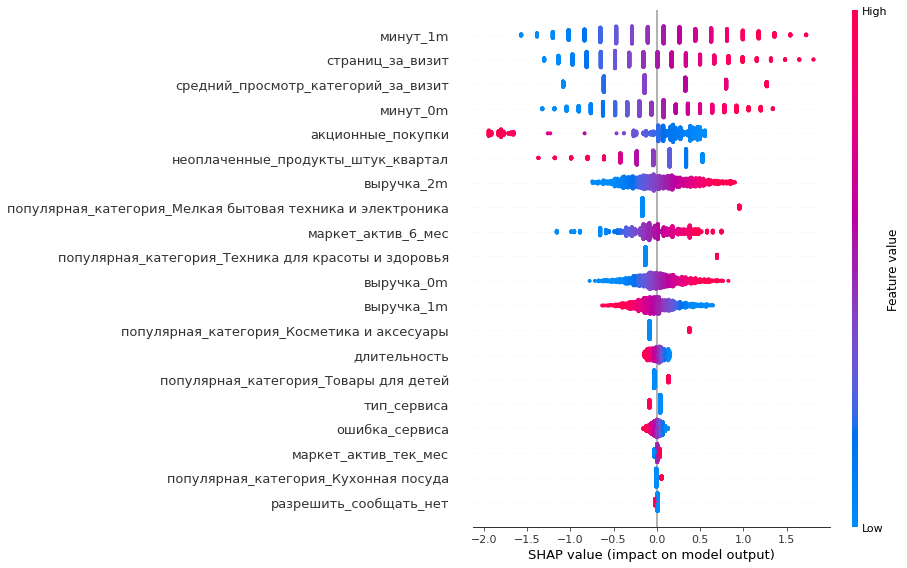

In [71]:
shap.plots.beeswarm(shap_values, max_display=30)

По диаграмме высокое влияние оказывает время проведенное на сайте, а также акционные покупки и неоплаченные покупки. Данные по выручке скорее производная от величин, которых нет в датасете.

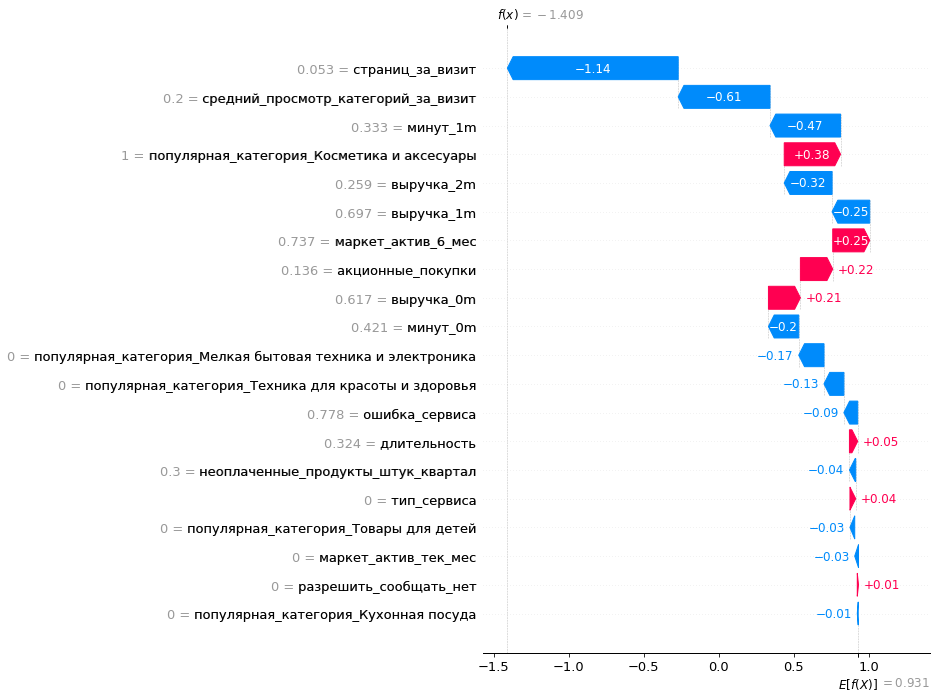

In [72]:
shap.plots.waterfall(shap_values[5], max_display=20) 

По диаграмме вывод схож с предыдущим

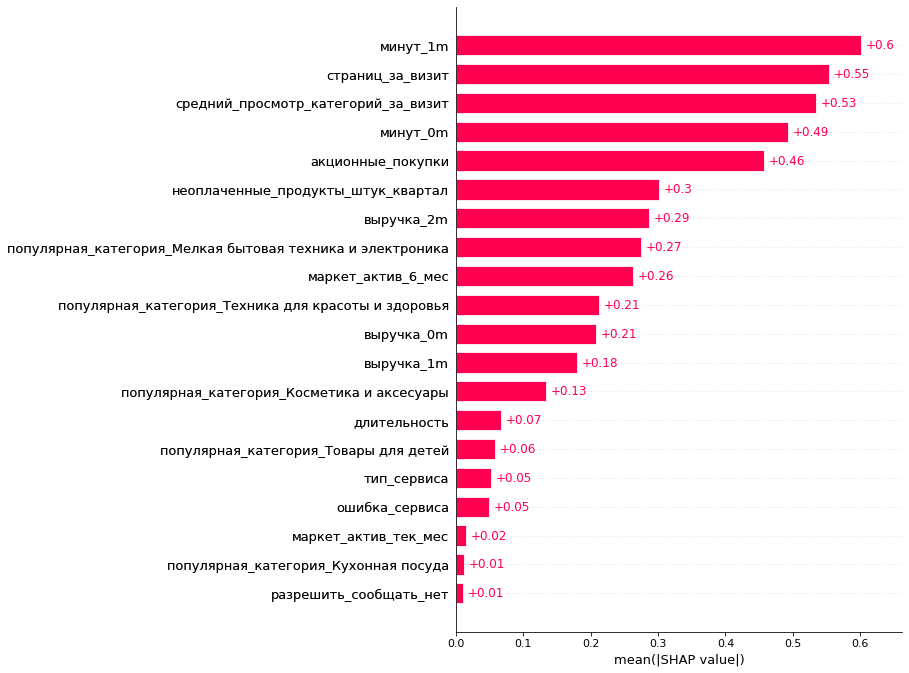

In [73]:
shap.plots.bar(shap_values, max_display=20) 

1) По диаграмме вывод схож с предыдущим. При этом из категорий выбивается "техника" и "товары по уходу за телом".;<br>
2) Неоплаченные продукты заставляют задуматься о низком влиянии ошибок сервиса, ведь именно из-за ошибок могла отсутствовать оплата;<br>
3) Также интересна активность маркета, ведь она по влиянию на 7м месте из 20

### Вывод
.[В содержание](#content)
<a name='conclusion_analyze_importance'>

1) Наибольшее влияние на модель оказывает время взаимодействия с сайтом и его производные("просмотр категорий за визит" и т.д.);<br>
2) Из категорий товаров выделяются "техника" и "товары по уходу за телом";<br>
3) Для рекомендации стоит проверить влияние "ошибок сервиса", несмотря на его низкое влияние на модель;<br>
4) Взаимодейтсвие с клиентом является весомым фактором для сервиса;<br>
5) Акции способствует увеличению активности покупателя

## Сегментация покупателей
<a name='customer_segmentation'></a>
[В содержание](#content)

Сегментацию будем проводить исходя из вывода по анализу с применением SHAP:<br>
1) По категориям;<br>
2) Общая активность;<br>
3) Влияние ошибок;<br>
4) Активность маркета;<br>
5) Акционные покупки

### Исследование потенциальных проблем
<a name='customer_segmentation_research'></a>
[В содержание](#content)

1 - прежний уровень;<br>
0 - снижение актвиности

Для начала выберем вероятность и прогноз модели для объединения с неотмасштабированными и некодированными значениями

In [74]:
y_predicted = best_model_linear.predict(X_full_use_no_name)
df_y_predicted = pd.DataFrame(y_predicted, columns=['прогноз_активности'])
df_y_predicted['прогноз_активности'] = df_y_predicted['прогноз_активности'].apply(lambda x:
                                                                                 'прежняя' if x ==1
                                                                                 else 'снизилась')

y_proba = best_model_linear.predict_proba(X_full_use_no_name)
# y_proba, df_y_predicted
df_y_proba = pd.DataFrame(y_proba, columns=['снижение', 'прежняя'])

Для анализа вероятности будем использовать вероятность прежней активности - "прежняя"

In [75]:
for_explain = df_y_predicted.join(df_y_proba).join(X_full)
for_explain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   прогноз_активности                   1296 non-null   object 
 1   снижение                             1296 non-null   float64
 2   прежняя                              1296 non-null   float64
 3   тип_сервиса                          1296 non-null   object 
 4   разрешить_сообщать                   1296 non-null   object 
 5   маркет_актив_6_мес                   1296 non-null   float64
 6   маркет_актив_тек_мес                 1296 non-null   int64  
 7   длительность                         1296 non-null   int64  
 8   акционные_покупки                    1296 non-null   float64
 9   популярная_категория                 1296 non-null   object 
 10  средний_просмотр_категорий_за_визит  1296 non-null   int64  
 11  неоплаченные_продукты_штук_ква

Добавляем данные по общей выручке

In [76]:
for_explain['выручка_общая'] = for_explain[['выручка_0m', 'выручка_1m', 'выручка_2m']].sum(axis=1)
for_explain['выручка_общая'].head()

0    14659.6
1    15341.9
2    17561.4
3    16274.0
4    15251.0
Name: выручка_общая, dtype: float64

In [77]:
columns_predict = ['прогноз_активности', 'снижение', 'прежняя', 'выручка_общая']

Начнем анализ с акционных покупок

#### Доля покупок по акции

In [78]:
for_explain[[*columns_predict, 'акционные_покупки']].head()

,прогноз_активности,снижение,прежняя,выручка_общая,акционные_покупки
0,снизилась,0.923772,0.076228,14659.6,0.75
1,прежняя,0.428118,0.571882,15341.9,0.14
2,снизилась,0.847431,0.152569,17561.4,0.99
3,снизилась,0.977939,0.022061,16274.0,0.94
4,снизилась,0.610807,0.389193,15251.0,0.26


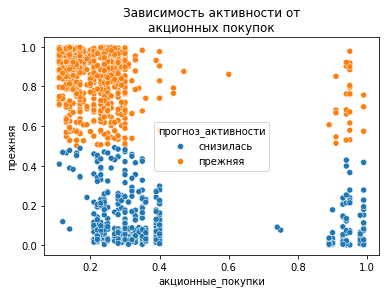

In [79]:
sns.scatterplot(for_explain,
                x='акционные_покупки',
                y='прежняя',
                hue='прогноз_активности')

plt.title('Зависимость активности от\nакционных покупок');

По графику рассеяния видно, что можно разбить покупателей на 2 группы, где границей можно взять долю акционныз покупок равной 70%

In [80]:
level_promo = 0.7
name_level_promo = ['менее 70%', 'более 70%']

def sale_promotion(x):
    if x < level_promo:
        return name_level_promo[0]
    else:
        return name_level_promo[1]

In [81]:
for_explain['level_promo'] = for_explain['акционные_покупки'].apply(sale_promotion)

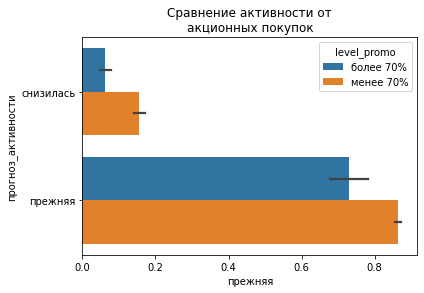

In [82]:
sns.barplot(for_explain, 
                x='прежняя',
                y='прогноз_активности',
                hue='level_promo')

plt.title('Сравнение активности от\nакционных покупок');

По данному графику общее влияние акций на сохранение активности мало

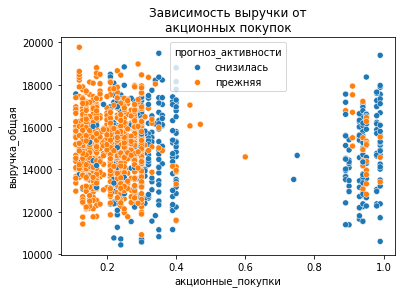

In [83]:
sns.scatterplot(for_explain,
                x='акционные_покупки',
                y='выручка_общая',
                hue='прогноз_активности')

plt.title('Зависимость выручки от\nакционных покупок');

Разница в выручке и доле акционных акций малоразличима

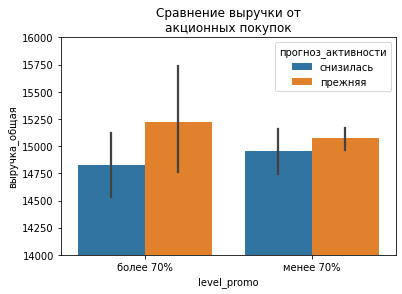

In [84]:
sns.barplot(for_explain, 
                x='level_promo',
                y='выручка_общая',
                hue='прогноз_активности')

plt.ylim(1.4*10**4, 1.6*10**4)
plt.title('Сравнение выручки от\nакционных покупок');

Данный график подтверждает вывод выше

#### Техника

In [85]:
for_explain['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

Для техники выберем все категории, имеющие это слово в названии

In [86]:
for_explain['техника'] = for_explain['популярная_категория'].isin(
    ['Мелкая бытовая техника и электроника',
        'Техника для красоты и здоровья']
).astype('int')

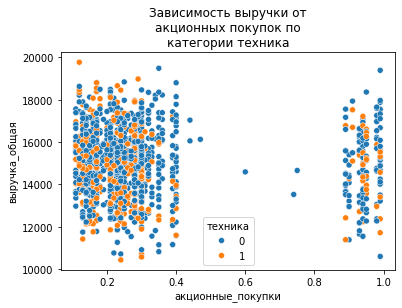

In [87]:
sns.scatterplot(for_explain,
                x='акционные_покупки',
                y='выручка_общая',
                hue='техника')

plt.title('Зависимость выручки от\nакционных покупок по\nкатегории техника');

Влияние акции на данную категорию малозаметна

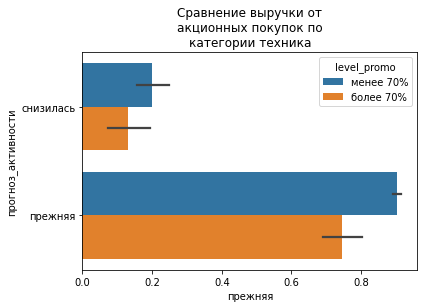

In [88]:
sns.barplot(for_explain[for_explain['техника'] > 0], 
                x='прежняя',
                y='прогноз_активности',
                hue='level_promo')

plt.title('Сравнение выручки от\nакционных покупок по\nкатегории техника');

Среди покупателей техники снижение заинтересованности меньше, чем без нее

#### Косметика

In [89]:
for_explain['уход_за_телом'] = for_explain['популярная_категория'].isin(
    ['Косметика и аксесуары']
).astype('int')

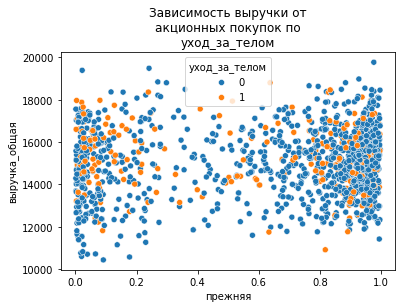

In [90]:
sns.scatterplot(for_explain, 
                x='прежняя',
                y='выручка_общая',
                hue='уход_за_телом')

plt.title('Зависимость выручки от\nакционных покупок по\nуход_за_телом');

основные значения выручки товаров ухода за телом находятся выше, чем большинства остальных категорий

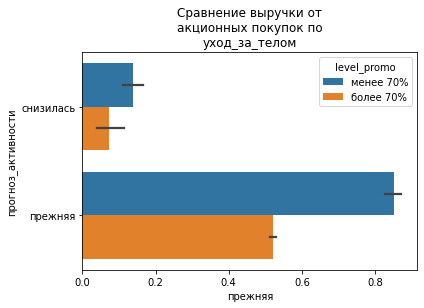

In [91]:
sns.barplot(for_explain[for_explain['уход_за_телом'] > 0], 
                x='прежняя',
                y='прогноз_активности',
                hue='level_promo')

plt.title('Сравнение выручки от\nакционных покупок по\nуход_за_телом');

Заинтересованность покупателей косметики ниже, чем остальных категорий

#### Товары для детей

In [92]:
for_explain['для_детей'] = for_explain['популярная_категория'].isin(
    ['Товары для детей']
).astype('int')

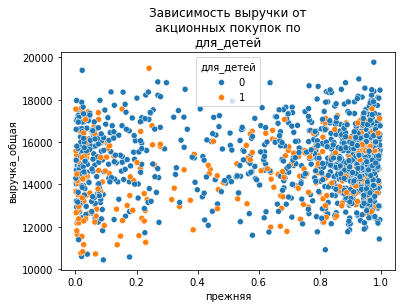

In [93]:
sns.scatterplot(for_explain, 
                x='прежняя',
                y='выручка_общая',
                hue='для_детей')

plt.title('Зависимость выручки от\nакционных покупок по\nдля_детей');

основные значения выручки товаров для детей находятся ниже, чем остальных категорий

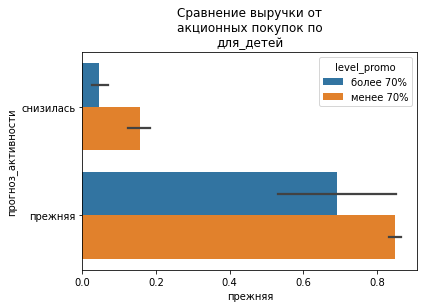

In [94]:
sns.barplot(for_explain[for_explain['для_детей'] > 0], 
                x='прежняя',
                y='прогноз_активности',
                hue='level_promo')

plt.title('Сравнение выручки от\nакционных покупок по\nдля_детей');

Заинтересованность покупателей товаров для детей также относителоьно невысока

#### Товары для дома

In [95]:
for_explain['для_дома'] = for_explain['популярная_категория'].isin(
    ['Домашний текстиль',
    'Кухонная посуда']
).astype('int')

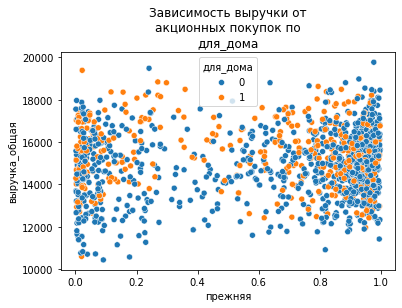

In [96]:
sns.scatterplot(for_explain, 
                x='прежняя',
                y='выручка_общая',
                hue='для_дома')

plt.title('Зависимость выручки от\nакционных покупок по\nдля_дома');

Основные значения выручки товаров для дома находятся выше, чем остальных категорий. Есть предположение, что это наиболее прибыльная категория

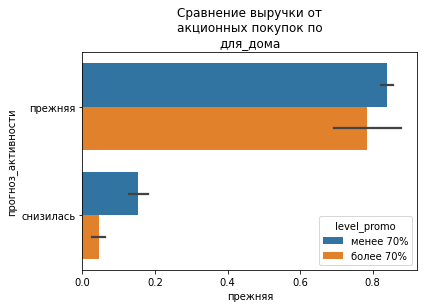

In [97]:
sns.barplot(for_explain[for_explain['для_дома'] > 0], 
                x='прежняя',
                y='прогноз_активности',
                hue='level_promo')

plt.title('Сравнение выручки от\nакционных покупок по\nдля_дома');

Заинтересованность в акциях покупателей товаров для дома также относителоьно невысока

#### Выручка и изменение активности

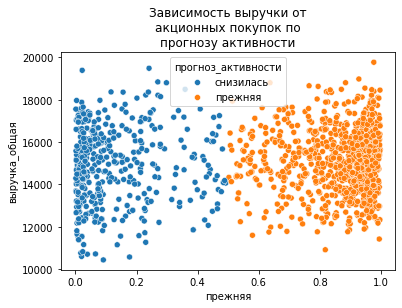

In [98]:
sns.scatterplot(for_explain,
                x='прежняя',
                y='выручка_общая',
                hue='прогноз_активности')

plt.title('Зависимость выручки от\nакционных покупок по\nпрогнозу активности');

Выручка от пользователей со снижением активности имеет большую дисперсию, а также выбивающиеся значения стремящиеся к 0

#### Частота встречи ошибок на сайте

In [99]:
for_explain['общее_время'] = for_explain[['минут_0m', 'минут_1m']].sum(axis=1)
for_explain['ошибок_в_минуту'] = (for_explain['ошибка_сервиса'] /\
                                  for_explain['общее_время']).fillna(0)
for_explain['отсутсвие_оплаты_от_ошибок'] = (for_explain['неоплаченные_продукты_штук_квартал'] /\
                                             for_explain['ошибка_сервиса']).fillna(0)

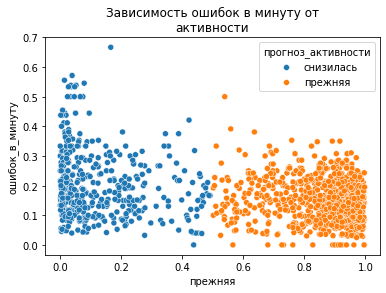

In [100]:
sns.scatterplot(for_explain,
                x='прежняя',
                y='ошибок_в_минуту',
                hue='прогноз_активности')

plt.title('Зависимость ошибок в минуту от\nактивности');

Среди пользователей со снижающейся активностью заметно большее соотношение встречающихся ошибок по сравнению с прежней активностью

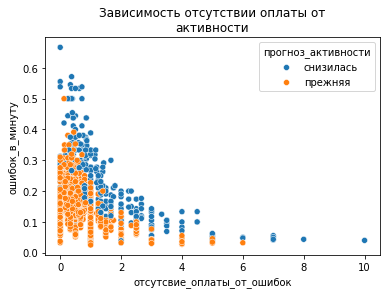

In [101]:
sns.scatterplot(for_explain,
                x='отсутсвие_оплаты_от_ошибок',
                y='ошибок_в_минуту',
                hue='прогноз_активности')

plt.title('Зависимость отсутствии оплаты от\nактивности');

Теория с отстутствием оплаты не подтвердилась, но при возрастающем количестве ошибок уменьшается количество неоплаты. Возможно ошибки не позволяют оформить заказ.

#### Активность маркета

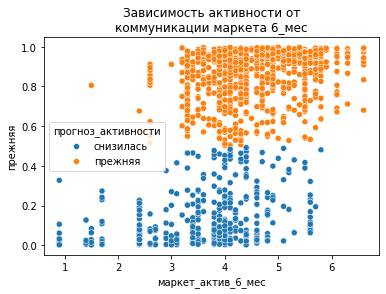

In [102]:
sns.scatterplot(for_explain,
                x='маркет_актив_6_мес',
                y='прежняя',
                hue='прогноз_активности')

plt.title('Зависимость активности от\nкоммуникации маркета 6_мес');

На графике явно видна зависимость частоты взаимодействия маркета с пользователями

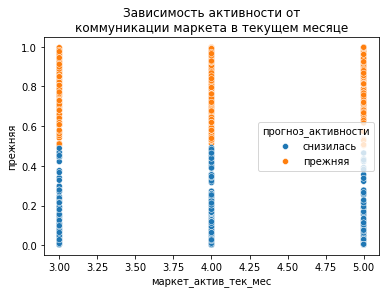

In [103]:
sns.scatterplot(for_explain,
                x='маркет_актив_тек_мес',
                y='прежняя',
                hue='прогноз_активности')

plt.title('Зависимость активности от\nкоммуникации маркета в текущем месяце');

По этому графику видно, что стоит произвести ранжирование активности маркета. Также ранжируем потенциально снижающуюся активность.

Функция для ранжирования

In [104]:
list_rank_active_name = ['0_низкая', '1_средняя', '2_высокая']
list_rank_active_filter = [3, 4, 5]

def rank_active(x):
    if x == list_rank_active_filter[0]:
        return list_rank_active_name[0]
    elif x == list_rank_active_filter[1]:
        return list_rank_active_name[1]
    else:
        return list_rank_active_name[2]

list_rank_predict_name = ['0_снизилась', '1_потенциальное снижение', '2_прежняя']
list_rank_predict_filter = [0.33, 0.67, 1.01]
def rank_predict(x):
    if x <= list_rank_predict_filter[0]:
        return list_rank_predict_name[0]
    elif x < list_rank_predict_filter[1]:
        return list_rank_predict_name[1]
    else:
        return list_rank_predict_name[2]

In [105]:
market_active_0m = for_explain[['прежняя', 'маркет_актив_6_мес', 'прогноз_активности']]
display(market_active_0m.head())
market_active_0m['rank_market_active_0m'] = market_active_0m['маркет_актив_6_мес'].\
    apply(rank_active)
display(market_active_0m.head())
market_active_0m['rank_predict_прежняя'] = market_active_0m['прежняя'].\
    apply(rank_predict)
display(market_active_0m['rank_market_active_0m'].unique())

,прежняя,маркет_актив_6_мес,прогноз_активности
0,0.076228,4.4,снизилась
1,0.571882,4.9,прежняя
2,0.152569,3.2,снизилась
3,0.022061,5.1,снизилась
4,0.389193,3.3,снизилась


/tmp/ipykernel_142/1136143040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_active_0m['rank_market_active_0m'] = market_active_0m['маркет_актив_6_мес'].\


,прежняя,маркет_актив_6_мес,прогноз_активности,rank_market_active_0m
0,0.076228,4.4,снизилась,2_высокая
1,0.571882,4.9,прежняя,2_высокая
2,0.152569,3.2,снизилась,2_высокая
3,0.022061,5.1,снизилась,2_высокая
4,0.389193,3.3,снизилась,2_высокая


/tmp/ipykernel_142/1136143040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_active_0m['rank_predict_прежняя'] = market_active_0m['прежняя'].\


array(['2_высокая', '0_низкая', '1_средняя'], dtype=object)

In [106]:
market_active_0m['rank_market_active_0m'].unique(),\
market_active_0m['rank_predict_прежняя'].unique()

(array(['2_высокая', '0_низкая', '1_средняя'], dtype=object),
 array(['0_снизилась', '1_потенциальное снижение', '2_прежняя'],
       dtype=object))

In [107]:
agg_market_active = market_active_0m.\
    groupby(by=['rank_market_active_0m',
                'rank_predict_прежняя']).mean().reset_index(drop=False)

agg_market_active = agg_market_active.sort_values(by='rank_predict_прежняя')

In [108]:
agg_market_active

,rank_market_active_0m,rank_predict_прежняя,прежняя,маркет_актив_6_мес
0,0_низкая,0_снизилась,0.053386,3.000000
2,1_средняя,0_снизилась,0.101139,4.000000
5,2_высокая,0_снизилась,0.089354,3.495509
3,1_средняя,1_потенциальное снижение,0.527027,4.000000
6,2_высокая,1_потенциальное снижение,0.529412,4.247934
1,0_низкая,2_прежняя,0.911465,3.000000
4,1_средняя,2_прежняя,0.854614,4.000000
7,2_высокая,2_прежняя,0.892488,4.645623


Далее построим графики для отображения активности маркета и влияния на покупателей

In [109]:
def barplot_market_active(num_filter_column):
    filter_ = list_rank_predict_name[num_filter_column]
    filtered_data = agg_market_active[agg_market_active['rank_predict_прежняя']==filter_]
    
    sns.barplot(filtered_data.sort_values(by='прежняя', ascending=False),
                y='rank_market_active_0m',
                x='прежняя',
               hue='rank_market_active_0m')
    
    return filtered_data

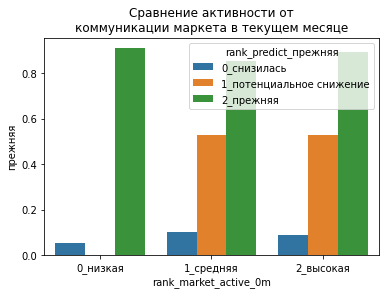

In [110]:
sns.barplot(agg_market_active,
            x='rank_market_active_0m',
            y='прежняя',
            hue='rank_predict_прежняя')

plt.title('Сравнение активности от\nкоммуникации маркета в текущем месяце');

По данному графику видно, что активность маркета является фактором повышающим активность

### Определение общего вывода потенциального снижения активности
.[В содержание](#content)
<a name='customer_segmentation_research_problems'>

Для получения общей картины по уходящим клиентам рассмотрим диапозон с активностью, который является промежуточным (от 1/3 до 2/3 вероятности). Клиенты с низкой активностью (до 1/3) менее показательны. Также, для начального этапа по сохранению активности удержать клиентов, которые потенциально "уходят", легче, чем вернуть "ушедших".<br>
Также интересно отметить как ошибки на сайте влияют на поведение клиентов. Поэтому учтем частоту встречаемости ошибок.

<font color='purple'><b>Комментарий студента</b></font><br>
Добавил П9.3. для сравнения анализа ДО и ПОСЛЕ

In [111]:
min_limit, max_limit = 0.33, 0.67
for_explain_final = for_explain[
    ((min_limit < for_explain['прежняя']) & (for_explain['прежняя'] < max_limit))==True
]
for_explain_final.head()

,прогноз_активности,снижение,прежняя,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,минут_1m,выручка_общая,level_promo,техника,уход_за_телом,для_детей,для_дома,общее_время,ошибок_в_минуту,отсутсвие_оплаты_от_ошибок
1,прежняя,0.428118,0.571882,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,...,8,15341.9,менее 70%,0,0,0,1,21,0.047619,2.000000
4,снизилась,0.610807,0.389193,стандарт,да,3.3,4,762,0.26,Домашний текстиль,...,10,15251.0,менее 70%,0,0,0,1,20,0.050000,1.000000
8,прежняя,0.382291,0.617709,стандарт,да,4.7,4,450,0.13,Домашний текстиль,...,14,12424.5,менее 70%,0,0,0,1,24,0.250000,0.333333
10,снизилась,0.669748,0.330252,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,...,11,14786.7,менее 70%,1,0,0,0,24,0.083333,2.500000
15,снизилась,0.558815,0.441185,стандарт,нет,3.8,3,209,0.22,Товары для детей,...,8,14708.9,менее 70%,0,0,1,0,22,0.318182,0.428571


In [112]:
def check_feature(list_columns:list, group_column, x_label, y_label, hue_label):
    data_ = for_explain_final[
        list_columns
    ].groupby(by=group_column).mean().reset_index(drop=False)
    display(data_)
    sns.barplot(data_, 
                x=x_label,
                y=y_label,
                hue=hue_label)

,маркет_актив_тек_мес,техника,прежняя
0,3,0,0.547875
1,3,1,0.491635
2,4,0,0.528097
3,4,1,0.531429
4,5,0,0.505230
5,5,1,0.542543


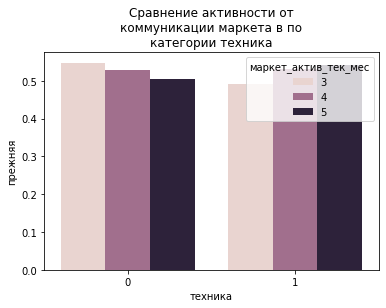

In [113]:
check_feature(['техника', 'прежняя', 'маркет_актив_тек_мес'],
             ['маркет_актив_тек_мес', 'техника'],
             'техника',
             'прежняя',
             'маркет_актив_тек_мес')

plt.title('Сравнение активности от\nкоммуникации маркета в по\nкатегории техника');

По данному графику видно, что высокая активность маркета негативно влияет на покупателей техники

,level_promo,техника,прежняя
0,более 70%,0,0.526773
1,более 70%,1,0.533359
2,менее 70%,0,0.530189
3,менее 70%,1,0.523675


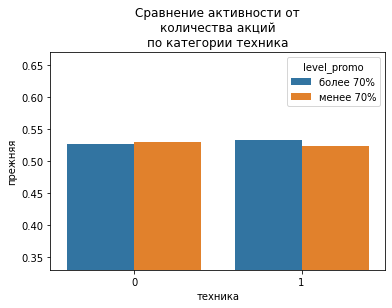

In [114]:
check_feature(['техника', 'прежняя', 'level_promo'],
             ['level_promo', 'техника'],
             'техника',
             'прежняя',
             'level_promo')

plt.ylim(min_limit, max_limit)

plt.title('Сравнение активности от\nколичества акций\nпо категории техника');

Но для покупателей техники акции имеют некоторое влияние, возможно одно из самых высоких по сравнению с другими категориями

,маркет_актив_тек_мес,уход_за_телом,прежняя
0,3,0,0.533257
1,3,1,0.557484
2,4,0,0.531508
3,4,1,0.516601
4,5,0,0.516202
5,5,1,0.504157


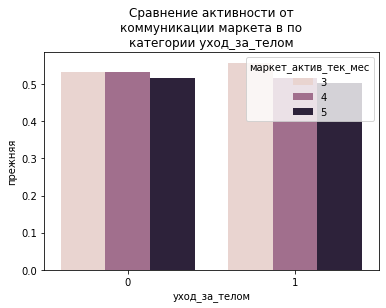

In [115]:
check_feature(['маркет_актив_тек_мес', 'прежняя', 'уход_за_телом'],
             ['маркет_актив_тек_мес', 'уход_за_телом'],
             'уход_за_телом',
             'прежняя',
             'маркет_актив_тек_мес')

plt.title('Сравнение активности от\nкоммуникации маркета в по\nкатегории уход_за_телом');

Для покупателей косметики большое количество сообщений также негативно влияет на заинтересованность

,level_promo,уход_за_телом,прежняя
0,более 70%,0,0.544713
1,более 70%,1,0.480754
2,менее 70%,0,0.526935
3,менее 70%,1,0.539131


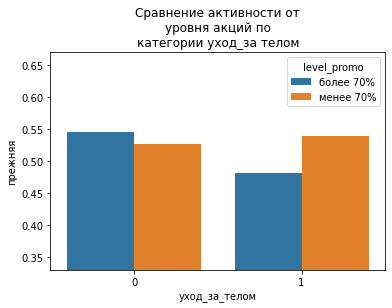

In [116]:
check_feature(['level_promo', 'прежняя', 'уход_за_телом'],
             ['level_promo', 'уход_за_телом'],
             'уход_за_телом',
             'прежняя',
             'level_promo')

plt.ylim(min_limit, max_limit)

plt.title('Сравнение активности от\nуровня акций по\nкатегории уход_за телом');

По данному графику акции мало влияют наданную категорию

,маркет_актив_тек_мес,для_детей,прежняя
0,3,0,0.548169
1,3,1,0.513308
2,4,0,0.519727
3,4,1,0.551039
4,5,0,0.515283
5,5,1,0.515251


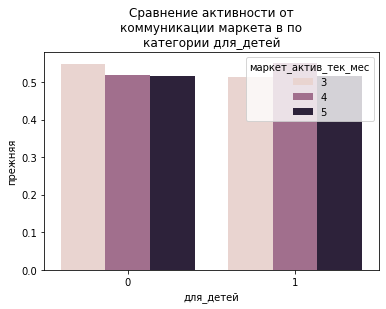

In [117]:
check_feature(['маркет_актив_тек_мес', 'прежняя', 'для_детей'],
             ['маркет_актив_тек_мес', 'для_детей'],
             'для_детей',
             'прежняя',
             'маркет_актив_тек_мес')

plt.title('Сравнение активности от\nкоммуникации маркета в по\nкатегории для_детей');

Для покупателей товаров для детей наоборот интересны предложения маркета

,level_promo,для_детей,прежняя
0,более 70%,0,0.531013
1,более 70%,1,0.530928
2,менее 70%,0,0.526325
3,менее 70%,1,0.535152


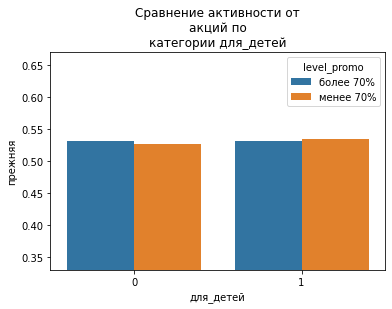

In [118]:
check_feature(['level_promo', 'прежняя', 'для_детей'],
             ['level_promo', 'для_детей'],
             'для_детей',
             'прежняя',
             'level_promo')

plt.ylim(min_limit, max_limit)

plt.title('Сравнение активности от\nакций по\nкатегории для_детей');

Акции на эту категорию имеют достаточное влияние на данную категорию

,маркет_актив_тек_мес,для_дома,прежняя
0,3,0,0.524010
1,3,1,0.567813
2,4,0,0.535926
3,4,1,0.510001
4,5,0,0.526508
5,5,1,0.499959


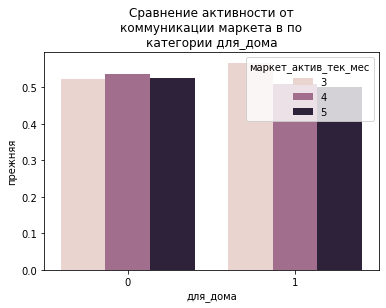

In [119]:
check_feature(['маркет_актив_тек_мес', 'прежняя', 'для_дома'],
             ['маркет_актив_тек_мес', 'для_дома'],
             'для_дома',
             'прежняя',
             'маркет_актив_тек_мес')

plt.title('Сравнение активности от\nкоммуникации маркета в по\nкатегории для_дома');

Активность маркета на эту категорию влияет негативно

,level_promo,для_дома,прежняя
0,более 70%,0,0.521033
1,более 70%,1,0.660676
2,менее 70%,0,0.532818
3,менее 70%,1,0.521677


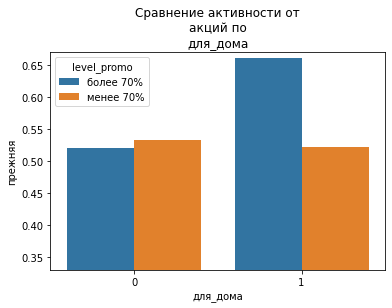

In [120]:
check_feature(['level_promo', 'прежняя', 'для_дома'],
             ['level_promo', 'для_дома'],
             'для_дома',
             'прежняя',
             'level_promo')

plt.ylim(min_limit, max_limit)

plt.title('Сравнение активности от\nакций по\nдля_дома');

Акции имеют самое высокое влияние на товары для дома. Также виден высокий потенциал для сохранения этих пользователей

### Сегментация пользователей и анализ
.[В содержание](#content)
<a name='customer_segmentation_segmentation'>

Для сегментации разобьем данные на 3 участка:<br>
1) Активность снижающася с высокой вероятностью и высокой доходностью;<br>
2) Активность снижающаяся с меньше вероятностью;<br>
3) Низкие показатели по активности и прибыли:<br>
Границы будут взяты в первую очередь при явном разделении данных, во вторую будет взята верхняя часть данных

Также добавим ранжирование для ошибок в минуту для будущего анализа

In [121]:
describe_errore_in_minute = for_explain['ошибок_в_минуту'].describe()

In [122]:
def error_in_minute(x):
    if x < describe_errore_in_minute[4]:
        return 'минимум'
    elif x < describe_errore_in_minute[5]:
        return 'умеренное'
    elif x < describe_errore_in_minute[6]:
        return 'высокое'
    else:
        return 'критичное'

In [123]:
for_explain['rank_market_active'] = for_explain['маркет_актив_6_мес'].apply(rank_active)

In [124]:
for_explain['rank_error'] = for_explain['ошибок_в_минуту'].apply(error_in_minute)

Ниже сегментирование пользователей

''

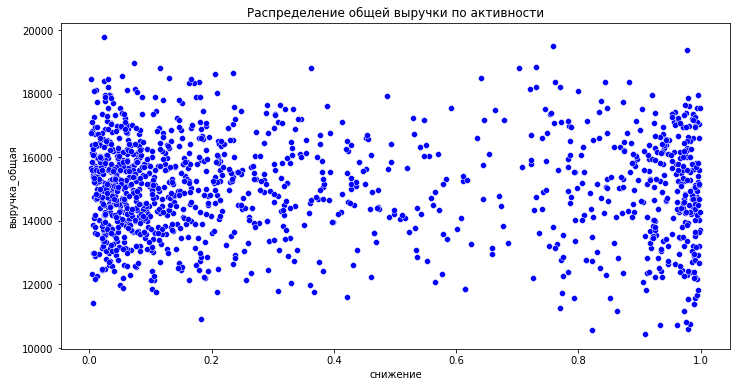

In [125]:
plt.figure(figsize=(12,6))
sns.scatterplot(for_explain, x='снижение', y='выручка_общая', color='blue')
plt.title('Распределение общей выручки по активности')
;

По данному графику хорошо видно высокую разреженность данных в промежутке [0.4: 0.8] по столбцу "снижение"

''

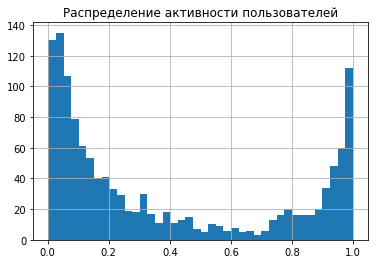

In [126]:
for_explain['снижение'].hist(bins=40)
plt.title('Распределение активности пользователей')
;

Для активности наблюдается явный перегиб при значении 0.7

''

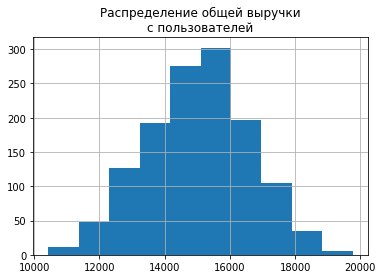

In [127]:
for_explain['выручка_общая'].hist()
plt.title('Распределение общей выручки\nс пользователей')
;

Для выручки возьмем данные, которые входят в верхние 75 процентов, поскольку при снижении активности уменьшается и выручка, которую потенциально можно увеличить.

In [128]:
selected_evenue = for_explain['выручка_общая'].describe()
index_evenue = 4
print(f"Метрика из метода describe общей выручки:\n{selected_evenue.index[index_evenue]}")
display(selected_evenue)
selected_evenue = selected_evenue[index_evenue]

selected_predict = 0.675

Метрика из метода describe общей выручки:
25%


count     1296.000000
mean     15021.766975
std       1581.337135
min      10437.600000
25%      13954.325000
50%      15072.550000
75%      16087.025000
max      19766.500000
Name: выручка_общая, dtype: float64

также вынесем пользователей с высокой вероятностью снижения и выручкой менее выбранной в отдельный сегмент,  т.к. он будет искажать картину по пользователям с меньшей активностью

In [129]:
def new_segment_evenue(x):
    if x >= selected_evenue:
        return 1
    else:
        return 0
    
def new_segment_activity(x):
    if x >= selected_predict:
        return 1
    else:
        return 0

In [130]:
for_explain['высокая_выручка'] = for_explain['выручка_общая'].apply(new_segment_evenue)
for_explain['высокое_снижение'] = for_explain['снижение'].apply(new_segment_activity)
for_explain['сегмент'] = None

for_explain['сегмент'].loc[(for_explain['высокая_выручка'] == 1) & (for_explain['высокое_снижение'] == 1)] = 'целевой'
for_explain['сегмент'].loc[(for_explain['высокая_выручка'] == 0) & (for_explain['высокое_снижение'] == 1)] = 'побочный'
for_explain['сегмент'] = for_explain['сегмент'].fillna('остальные')

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


''

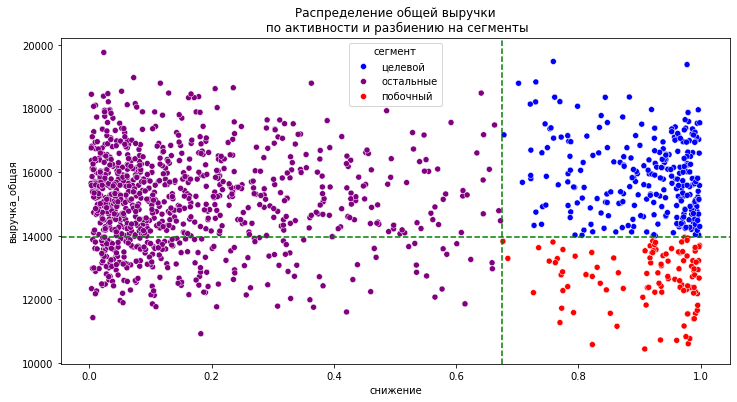

In [131]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    for_explain,
    x='снижение',
    y='выручка_общая',
    hue='сегмент',
    palette={
        'остальные': 'purple',
        'целевой': 'blue',
        'побочный': 'red'
    },
)

plt.axvline(x=selected_predict, color='green', linestyle='--')
plt.axhline(y=selected_evenue, color='green', linestyle='--')

plt.title('Распределение общей выручки\n по активности и разбиению на сегменты')
;

По данном графике визуально представлено сегментирование пользователей

В первую очередь исследуем влияние акций на сегменты

In [132]:
count_by_segment = for_explain[
        ['сегмент', 'level_promo']
    ].groupby(by='сегмент').count().reset_index(drop=False).rename(columns={'level_promo': 'всего'})

display(count_by_segment)

,сегмент,всего
0,остальные,916
1,побочный,110
2,целевой,270


In [133]:
def check_parameter(list_columns:list, group_column, x_label, y_label, hue_label, head_table=None):
    data_ = for_explain[
        list_columns
    ].groupby(by=group_column).count().reset_index(drop=False)
    
    data_ = data_.rename(columns=({y_label: 'количество'})).sort_values(by='количество')
    data_ = data_.merge(count_by_segment, on='сегмент', how='left')
    data_['процент от количества по сегментам'] = round(data_['количество'] / data_['всего'] * 100, 1)
    if head_table != 0:
        display(data_.head(head_table))
    
    sns.barplot(data_, 
                x=x_label,
                y='процент от количества по сегментам',
                hue=hue_label)

,level_promo,сегмент,количество,всего,процент от количества по сегментам
0,более 70%,остальные,32,916,3.5
1,более 70%,побочный,42,110,38.2
2,менее 70%,побочный,68,110,61.8
3,более 70%,целевой,92,270,34.1
4,менее 70%,целевой,178,270,65.9
5,менее 70%,остальные,884,916,96.5


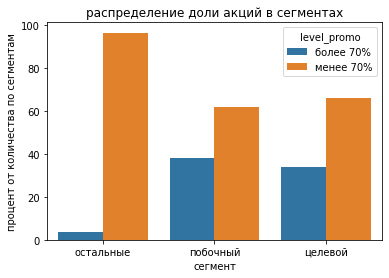

In [134]:
check_parameter(
    ['level_promo', 'сегмент', 'rank_market_active'],
    ['level_promo', 'сегмент'],
    'сегмент',
    'rank_market_active',
    'level_promo'
)

plt.title('распределение доли акций в сегментах');

По активности сегменты "побочный", "целевой" находятся с одной стороны и видно, что у пользвоателей со снижающейся активностью доля акций выше.

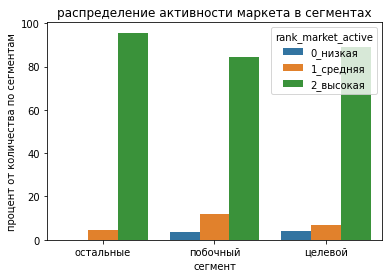

In [135]:
check_parameter(
    ['выручка_общая', 'сегмент', 'rank_market_active'],
    ['rank_market_active', 'сегмент'],
    'сегмент',
    'выручка_общая',
    'rank_market_active',
    head_table=0
)

plt.title('распределение активности маркета в сегментах');

По графикам видно позитивное влияние на заинтересованность коммуникации маркета

,rank_error,сегмент,количество,всего,процент от количества по сегментам
0,умеренное,побочный,24,110,21.8
1,минимум,побочный,25,110,22.7
2,высокое,побочный,29,110,26.4
3,критичное,побочный,32,110,29.1
4,минимум,целевой,41,270,15.2
5,высокое,целевой,48,270,17.8
6,умеренное,целевой,59,270,21.9
7,критичное,целевой,122,270,45.2
8,критичное,остальные,178,916,19.4
9,умеренное,остальные,239,916,26.1


Text(0.5, 1.0, 'Частоста встречаемости ошибок по сегментам')

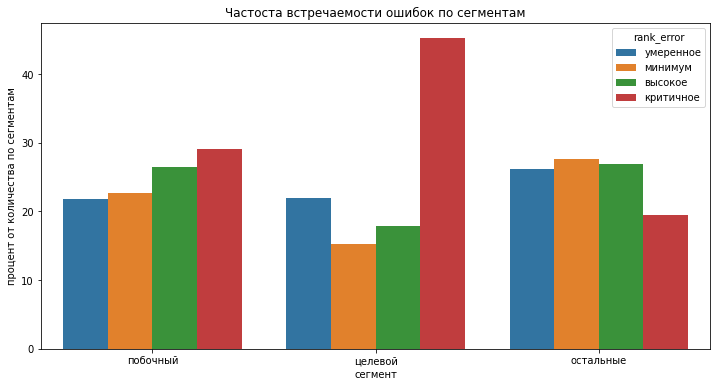

In [136]:
plt.figure(figsize=(12,6))

check_parameter(
    ['выручка_общая', 'сегмент', 'rank_error'],
    ['rank_error', 'сегмент'],
    'сегмент',
    'выручка_общая',
    'rank_error',
    head_table=12
)

plt.title('Частоста встречаемости ошибок по сегментам')

Доля пользователей с "критической" частотой встречи ошибок среди аудитории с низкой активностью значительно выше, чем у "остальных"

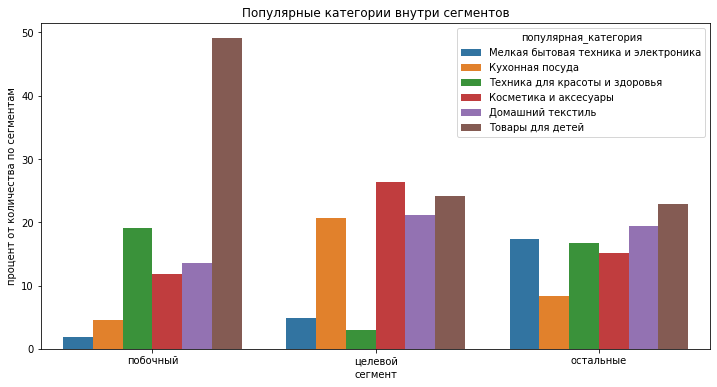

In [137]:
plt.figure(figsize=(12,6))

check_parameter(
    ['выручка_общая', 'сегмент', 'популярная_категория'],
    ['популярная_категория', 'сегмент'],
    'сегмент',
    'выручка_общая',
    'популярная_категория',
    head_table=0
)

plt.title('Популярные категории внутри сегментов');

Основной товар для целевого мегмента косметика, далее рассмотрим количество акций для всех категорий

In [138]:
count_by_category = for_explain[
        ['популярная_категория', 'level_promo']
    ].groupby(by='популярная_категория').count().reset_index(drop=False).rename(columns={'level_promo': 'всего'})

display(count_by_segment)

,сегмент,всего
0,остальные,916
1,побочный,110
2,целевой,270


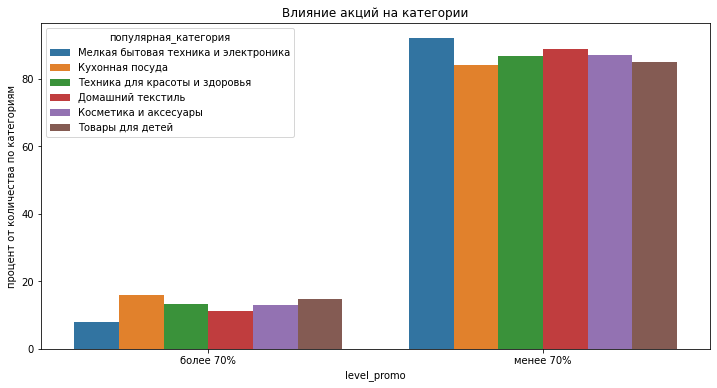

In [139]:
plt.figure(figsize=(12,6))

data_ = for_explain[
    ['выручка_общая', 'level_promo', 'популярная_категория']
].groupby(by=['level_promo', 'популярная_категория']).count().reset_index(drop=False)

data_ = data_.rename(columns=({'выручка_общая': 'количество'})).sort_values(by='количество')
data_ = data_.merge(count_by_category, on='популярная_категория', how='left')
data_['процент от количества по категориям'] = round(data_['количество'] / data_['всего'] * 100, 1)

sns.barplot(data_, 
            x='level_promo',
            y='процент от количества по категориям',
            hue='популярная_категория')

plt.title('Влияние акций на категории');

Значительная разница по акциям в категориях замечена только для "мелкой бытовой техники и электроники", а также кухонной посуды

### Вывод
.[В содержание](#content)
<a name='conclusion_customer_segmentation'>

Вывод по всему датасету:<br>
1) Акции имеют наибольшое влияние на технику и товары для дома;<br>
2) Товары для дома имеют наибольшую доходность. Также косметика является одной из наиболее прибыльных;<br>
3) Есть вероятность, что ошибки на сервисе снижают количество покупок;<br>
4) Среди снижающейся активности количество ошибок в минуту выше, чем у стабильных пользователей;<br>
5) Активность маркета имеет весомое значение на заинтересованность;<br>
<br>
Вывод для категории потенциально снижающейся активности:<br>
1) Для покупателей техники интересны акции и средняя активность маркета;<br>
2) Для покупателей косметики акции интересны как и других категорям в среднем, но удовлетворяет средняя активность маркета;<br>
3) Для покупателей товаров для детей акции имеют второстепенное значение, но положительно влияет высокая активность маркета;<br>
4) Для покупателей товаров для дома интересны акции.<br>
<br>
Общий вывод:
1) Необходимо варьировать количество сообщений от маркета, а также акции в зависимости от категорий;<br>
2) Подобрать подходящий период или товары с рассылкой по отдельным покупателям;<br>
3) Для повышения выручки уделить внимание покупателям косметики и товаров для дома;<br>
4) Минимизировать ошибки на сервисе и после проведения работ оценить как это повлияет на пользователей.

## Общий вывод
<a name='conclusion'></a>
[В содержание](#content)

### Описание проекта

Для магазина необходимо предсказать вероятность снижения активности пользователей на основе их поведения, взаимодействия с маркетом и ошибками на сайте.<br>
Причина - снижение активностей покупателей. Целевая аудитория покрыта, необходимо ее удержать

### Описание данных и их обработка

Магазин предоставил данные по:<br>
- Поведение покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (в проекте: market_action);<br>
- Выручка по покупателям и периодам (в проекте: market_evenue);<br>
- Время, котороео покупатель проводит на сайте (в проекте: market_period);<br>
- Среднемесячная прибыль с покупателя за последние 3 месяца (в проекте: evenue_3m);<br>

- В таблице по среднемесячной прибыли (evenue_3m) тип данных не соответствовал целевому (',' вместо '.'). Было исправлено.<br>
- Стандартизировано название столбцов;<br>
- Убраны неявные дубли в таблице 'market_action';<br>
- Убрано выбивающееся значение из таблицы 'market_evenue';<br>
- Все таблицы были объедены в одну. Также данные по месяцам были перемещены в столбцы

### Поиск лучше модели

Для поиска лучшей модели были использованы пайплайны;<br>
В качестве моделей для сравнения выбраны KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC поскольку перед нами задача бинарной классификации;<br>
В качестве кодировальщиков использовались OneHotEncoder и OrdinalEncodel;<br>
Для масштабирования были использованы StandartScaler, MinMaxScaler, а также сравнение без него.<br>
Модель проверялась с помощью критерия SHAP    

### Лучшая модель

Для поиска лучше модели используется RandomizedSearchCV как самый быстрый вариант

Лучшая модель:<br>
LogisticRegression<br>
Параметры:<br>
C=6, penalty='l1', solver='liblinear'<br>
<br>
Скейлер:<br>
MinMaxScaler<br>
<br>
Запуск пропусков:<br>
SimpleImputer<br>
Параметры:<br>
strategy='most_frequent'<br>

### Выводы и предложения (Дублирование из П.9.3)

Вывод по всему датасету:<br>
1) Акции имеют наибольшое влияние на технику;<br>
2) Товары для дома имеют наибольшую доходность. Также косметика является одной из наиболее прибыльных;<br>
3) Есть вероятность, что ошибки на сервисе снижают количество покупок;<br>
4) Среди снижающейся активности количество ошибок в минуту выше, чем у стабильных пользователей;<br>
5) Активность маркета имеет весомое значение на заинтересованность;<br>
<br>
Вывод для категории потенциально снижающейся активности:<br>
1) Для покупателей техники интересны акции и средняя активность маркета;<br>
2) Для покупателей косметики акции интересны как и других категорям в среднем, но удовлетворяет средняя активность маркета;<br>
3) Для покупателей товаров для детей акции имеют второстепенное значение, но положительно влияет высокая активность маркета;<br>
4) Для покупателей товаров для дома интересны редкие предложения, поскольку ни акции, ни высокая активность маркета несильно влияют на покупки.<br>
<br>
Общий вывод:
1) Необходимо варьировать количество сообщений от маркета, а также акции в зависимости от категорий;<br>
2) Подобрать подходящий период или товары с рассылкой по отдельным покупателям;<br>
3) Для повышения выручки уделить внимание покупателям косметики и товаров для дома;<br>
4) Минимизировать ошибки на сервисе и после проведения работ оценить как это повлияет на пользователей.